In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from polling_simulator import Demographic, Variable, generate_electorate, run_elections, run_polls
from polling_simulator.aggregation import naive_aggregation, stratified_aggregation, weight_by_self_reported_turnout
from polling_simulator.distributions import truncated_gaussian_distribution
from polling_simulator.sampling import predefined_sample

original_palette = sns.color_palette()
modified_palette = [original_palette[0], original_palette[3]]
sns.set_palette(modified_palette)

We can take the same age distribution, but this time instead of varying turnout we'll vary response rate.

In [2]:
age = Variable("age", truncated_gaussian_distribution(18, 35, 18, 110))

In [3]:
age_lt_30 = Demographic(
    turnout_likelihood=0.7,
    response_likelihood=0.3,
    candidate_preference={"Republican": 0.2, "Democrat": 0.8},
    population_segmentation=(age < 30)
)
age_between_30_50 = Demographic(
    turnout_likelihood=0.7,
    response_likelihood=0.5,
    candidate_preference={"Republican": 0.4, "Democrat": 0.6},
    population_segmentation=(age >= 30) & (age < 50)
)
age_between_50_65 = Demographic(
    turnout_likelihood=0.7,
    response_likelihood=0.7,
    candidate_preference={"Republican": 0.6, "Democrat": 0.4},
    population_segmentation=(age >= 50) & (age < 65)
)
age_ge_65 = Demographic(
    turnout_likelihood=0.7,
    response_likelihood=0.9,
    candidate_preference={"Republican": 0.75, "Democrat": 0.25},
    population_segmentation=(age >= 65)
)
demographics = [age_lt_30, age_between_30_50, age_between_50_65, age_ge_65]

In [4]:
np.random.seed(123)
electorate = generate_electorate(1000000, demographics)

In [5]:
demographic_size = [
    demographic.population_segmentation.segment(electorate).sum() / len(electorate)
    for demographic in demographics
]
demographic_size

[0.270689, 0.374323, 0.182993, 0.171995]

In [6]:
simulated_elections = run_elections(500, electorate)
simulated_elections["total_votes"] = simulated_elections.sum(axis=1)
simulated_elections["Democrat"] = simulated_elections["Democrat"] / simulated_elections["total_votes"]
simulated_elections["Republican"] = simulated_elections["Republican"] / simulated_elections["total_votes"]

(0.4, 0.6)

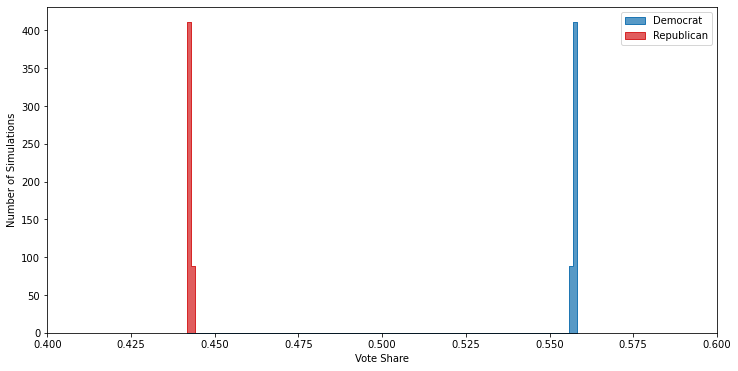

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    simulated_elections[["Democrat", "Republican"]], element="step", bins=100, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.4, 0.6])

In [8]:
# This cell may take ~10 minutes
naive_poll_results = run_polls(
    num_polls=500,
    num_to_poll=1000,
    electorate=electorate,
    sampling_strategy=predefined_sample(max_num_attempts=1, screen_likely_voters=False),
    aggregation_strategy=naive_aggregation()
)

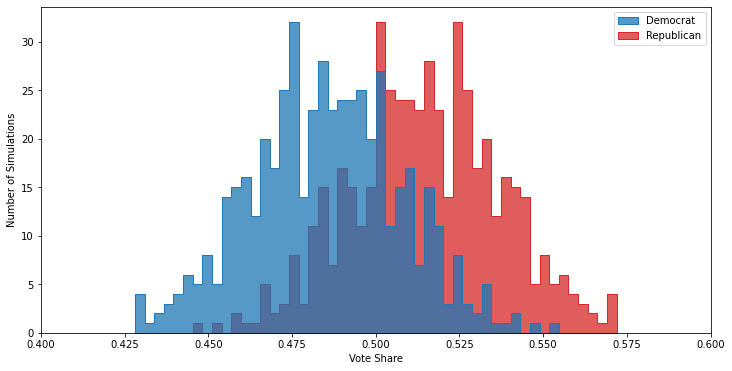

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    naive_poll_results[["Democrat", "Republican"]], element="step", bins=50, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.40, 0.60])
ax.get_legend().set_title("")

In [10]:
# This cell may take ~10 minutes
stratified_poll_results = run_polls(
    num_polls=500,
    num_to_poll=1000,
    electorate=electorate,
    sampling_strategy=predefined_sample(max_num_attempts=1, screen_likely_voters=False),
    aggregation_strategy=stratified_aggregation(demographics, demographic_size)
)

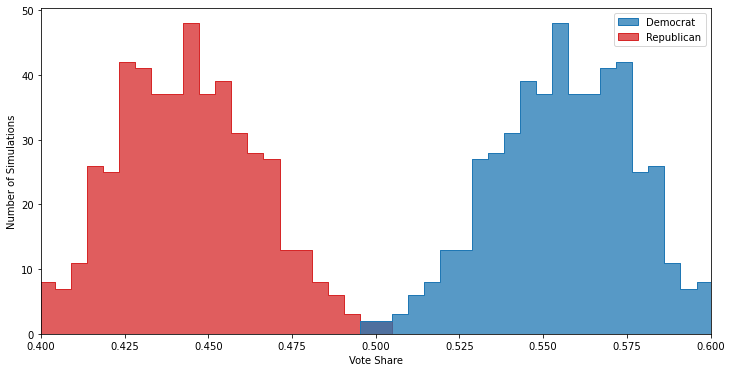

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    stratified_poll_results[["Democrat", "Republican"]], element="step", bins=50, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.40, 0.60])
ax.get_legend().set_title("")